In [42]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

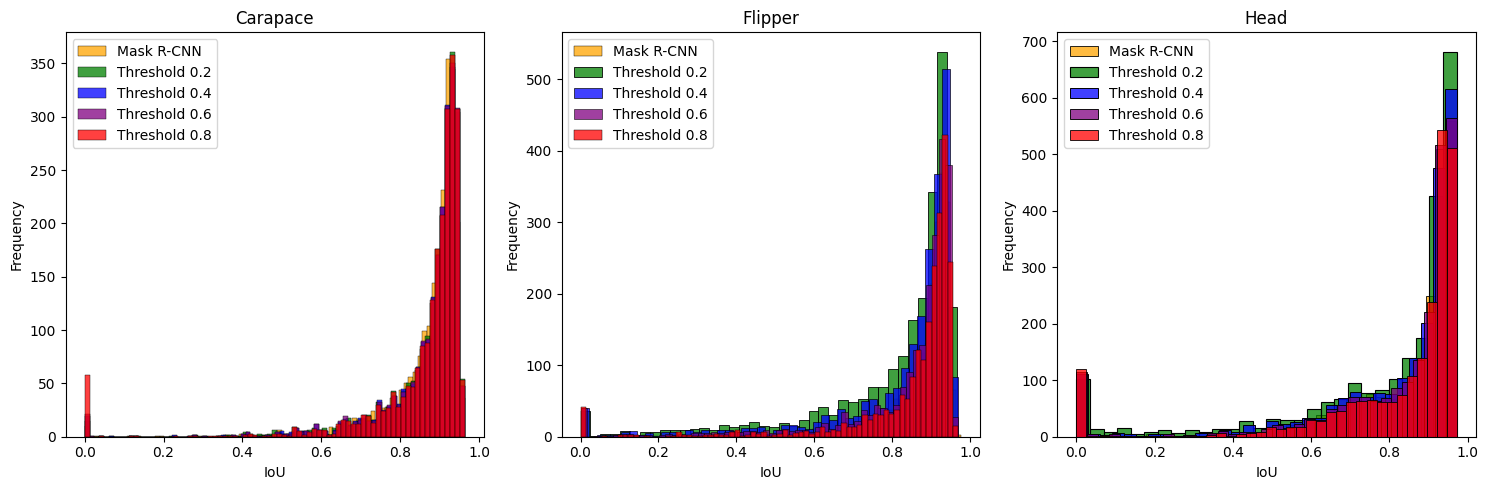

In [43]:
threshold_files = {
    '0.2': './DPMR02_iou_result.json',
    '0.4': './DPMR04_iou_result.json',
    '0.6': './DPMR06_iou_result.json',
    '0.8': './DPMR08_iou_result.json'
}

colors = {
    'Mask R-CNN': 'orange',
    '0.2': 'green',
    '0.4': 'blue',
    '0.6': 'purple',
    '0.8': 'red'
}

with open('./maskrcnn_iou_result.json', 'r') as file2:
    mask_rcnn_data = json.load(file2)

Carapace_ious_mrc = list(mask_rcnn_data['1'].values())
flipper_ious_mrc = list(mask_rcnn_data['2'].values())
head_ious_mrc = list(mask_rcnn_data['3'].values())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(Carapace_ious_mrc, ax=axs[0], color=colors['Mask R-CNN'], label='Mask R-CNN')
sns.histplot(flipper_ious_mrc, ax=axs[1], color=colors['Mask R-CNN'], label='Mask R-CNN')
sns.histplot(head_ious_mrc, ax=axs[2], color=colors['Mask R-CNN'], label='Mask R-CNN')

for threshold, filepath in threshold_files.items():
    with open(filepath, 'r') as file:
        data = json.load(file)
        
    Carapace_ious = list(data['1'].values())
    flipper_ious = list(data['2'].values())
    head_ious = list(data['3'].values())
    
    sns.histplot(Carapace_ious, ax=axs[0], color=colors[threshold], label=f'Threshold {threshold}')
    sns.histplot(flipper_ious, ax=axs[1], color=colors[threshold], label=f'Threshold {threshold}')
    sns.histplot(head_ious, ax=axs[2], color=colors[threshold], label=f'Threshold {threshold}')

axs[0].set_title('Carapace')
axs[0].set_xlabel('IoU')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].set_title('Flipper')
axs[1].set_xlabel('IoU')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].set_title('Head')
axs[2].set_xlabel('IoU')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()

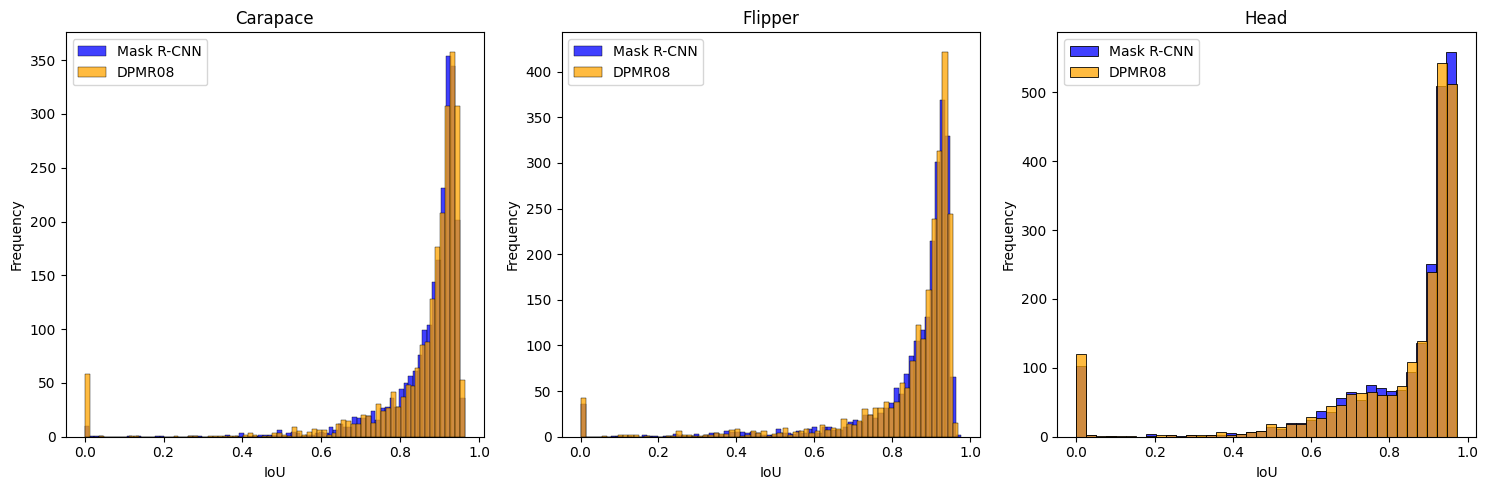

In [44]:


with open('./DPMR08_iou_result.json', 'r') as file1:
    dpmr08_data = json.load(file1)

Carapace_ious_dpmr08 = list(dpmr08_data['1'].values())
flipper_ious_dpmr08 = list(dpmr08_data['2'].values())
head_ious_dpmr08 = list(dpmr08_data['3'].values())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(Carapace_ious_mrc, ax=axs[0], color='blue', label='Mask R-CNN')
sns.histplot(Carapace_ious_dpmr08, ax=axs[0], color='orange', label='DPMR08')
axs[0].set_title('Carapace')
axs[0].set_xlabel('IoU')
axs[0].set_ylabel('Frequency')
axs[0].legend()

sns.histplot(flipper_ious_mrc, ax=axs[1], color='blue', label='Mask R-CNN')
sns.histplot(flipper_ious_dpmr08, ax=axs[1], color='orange', label='DPMR08')
axs[1].set_title('Flipper')
axs[1].set_xlabel('IoU')
axs[1].set_ylabel('Frequency')
axs[1].legend()

sns.histplot(head_ious_mrc, ax=axs[2], color='blue', label='Mask R-CNN')
sns.histplot(head_ious_dpmr08, ax=axs[2], color='orange', label='DPMR08')
axs[2].set_title('Head')
axs[2].set_xlabel('IoU')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()

In [45]:
def calculate_mean_iou(iou_results):
    mean_ious = {}
    category_map = {'1': "Carapace", '2': "Flipper", '3': "Head"}
    for cat_id, img_dict in iou_results.items():
        category = category_map[cat_id]
        ious = list(img_dict.values())
        mean_ious[category] = np.mean(ious) if ious else 0
    return mean_ious

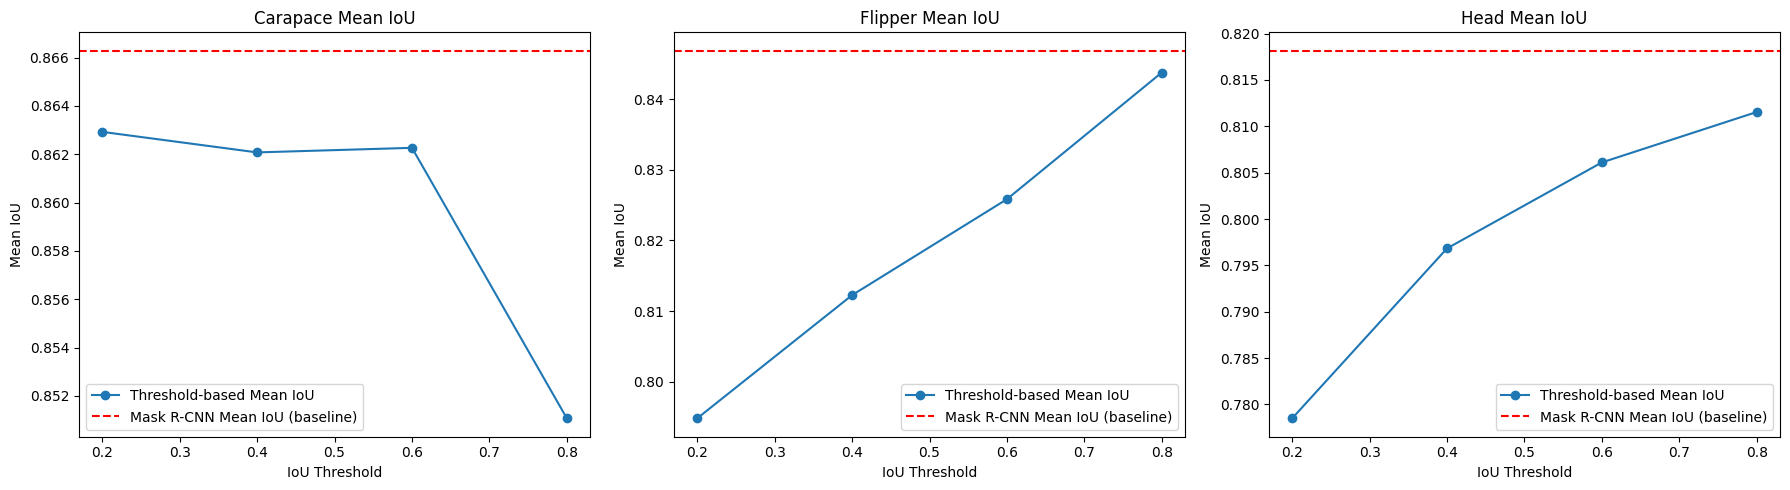

In [46]:
mask_rcnn_mean_iou = calculate_mean_iou(mask_rcnn_data)

mean_iou_results = {cat: [] for cat in ["Carapace", "Flipper", "Head"]}
thresholds = [0.2, 0.4, 0.6, 0.8]

for threshold, filepath in threshold_files.items():
    with open(filepath, 'r') as file:
        iou_data = json.load(file)
        
        mean_iou = calculate_mean_iou(iou_data)
        
        for cat in mean_iou_results:
            mean_iou_results[cat].append(mean_iou[cat])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
categories = ["Carapace", "Flipper", "Head"]

for i, category in enumerate(categories):
    axs[i].plot(thresholds, mean_iou_results[category], marker='o', label="Threshold-based Mean IoU")
    axs[i].axhline(y=mask_rcnn_mean_iou[category], color='r', linestyle='--', label="Mask R-CNN Mean IoU (baseline)")
    axs[i].set_title(f"{category} Mean IoU")
    axs[i].set_xlabel("IoU Threshold")
    axs[i].set_ylabel("Mean IoU")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [47]:
def calculate_sensitivity(iou_data, iou_threshold=0.5):
    sensitivity_counts = {"Carapace": {"TP": 0, "FN": 0}, "Flipper": {"TP": 0, "FN": 0}, "Head": {"TP": 0, "FN": 0}}
    category_map = {1: "Carapace", 2: "Flipper", 3: "Head"}
    
    for cat_id, ious in iou_data.items():
        category = category_map[int(cat_id)]
        for iou in ious.values():
            if iou >= iou_threshold:
                sensitivity_counts[category]["TP"] += 1
            else:
                sensitivity_counts[category]["FN"] += 1
                
    sensitivity = {cat: counts["TP"] / (counts["TP"] + counts["FN"]) if (counts["TP"] + counts["FN"]) > 0 else 0 
                    for cat, counts in sensitivity_counts.items()}
    return sensitivity

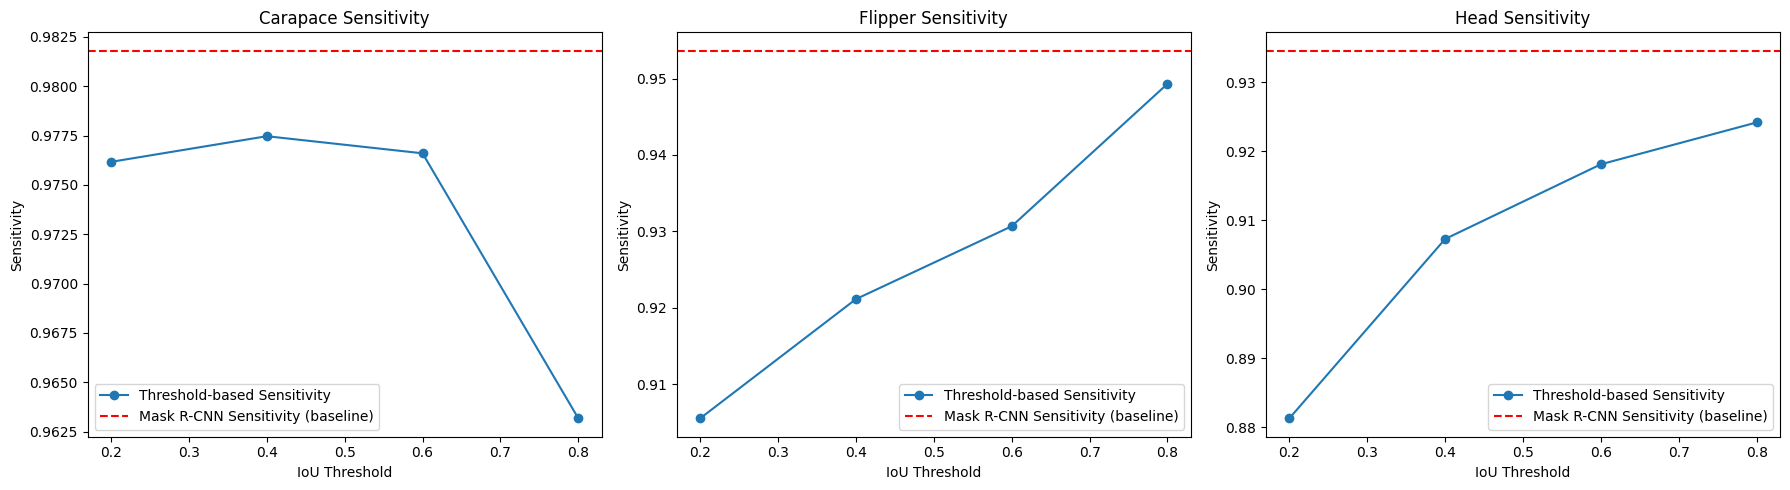

In [48]:
mask_rcnn_sensitivity = calculate_sensitivity(mask_rcnn_data)

sensitivity_results = {cat: [] for cat in ["Carapace", "Flipper", "Head"]}
thresholds = [0.2, 0.4, 0.6, 0.8]

for threshold, filepath in threshold_files.items():
    with open(filepath, 'r') as file:
        iou_data = json.load(file)
        sensitivity = calculate_sensitivity(iou_data)
        
        for cat in sensitivity_results:
            sensitivity_results[cat].append(sensitivity[cat])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
categories = ["Carapace", "Flipper", "Head"]

for i, category in enumerate(categories):
    axs[i].plot(thresholds, sensitivity_results[category], marker='o', label="Threshold-based Sensitivity")
    axs[i].axhline(y=mask_rcnn_sensitivity[category], color='r', linestyle='--', label="Mask R-CNN Sensitivity (baseline)")
    axs[i].set_title(f"{category} Sensitivity")
    axs[i].set_xlabel("IoU Threshold")
    axs[i].set_ylabel("Sensitivity")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [49]:
def calculate_fp_rate_from_iou_results(iou_results, iou_threshold=0.5):
    fp_counts = {"Carapace": 0, "Flipper": 0, "Head": 0}
    total_counts = {"Carapace": 0, "Flipper": 0, "Head": 0}
    
    category_map = {1: "Carapace", 2: "Flipper", 3: "Head"}
    
    for cat_id, img_dict in iou_results.items():
        category = category_map[int(cat_id)]
        
        for img_id, iou in img_dict.items():
            if iou < iou_threshold:
                fp_counts[category] += 1
            
            total_counts[category] += 1

    fp_rates = {cat: fp_counts[cat] / total_counts[cat] if total_counts[cat] > 0 else 0 for cat in fp_counts}
    
    return fp_rates

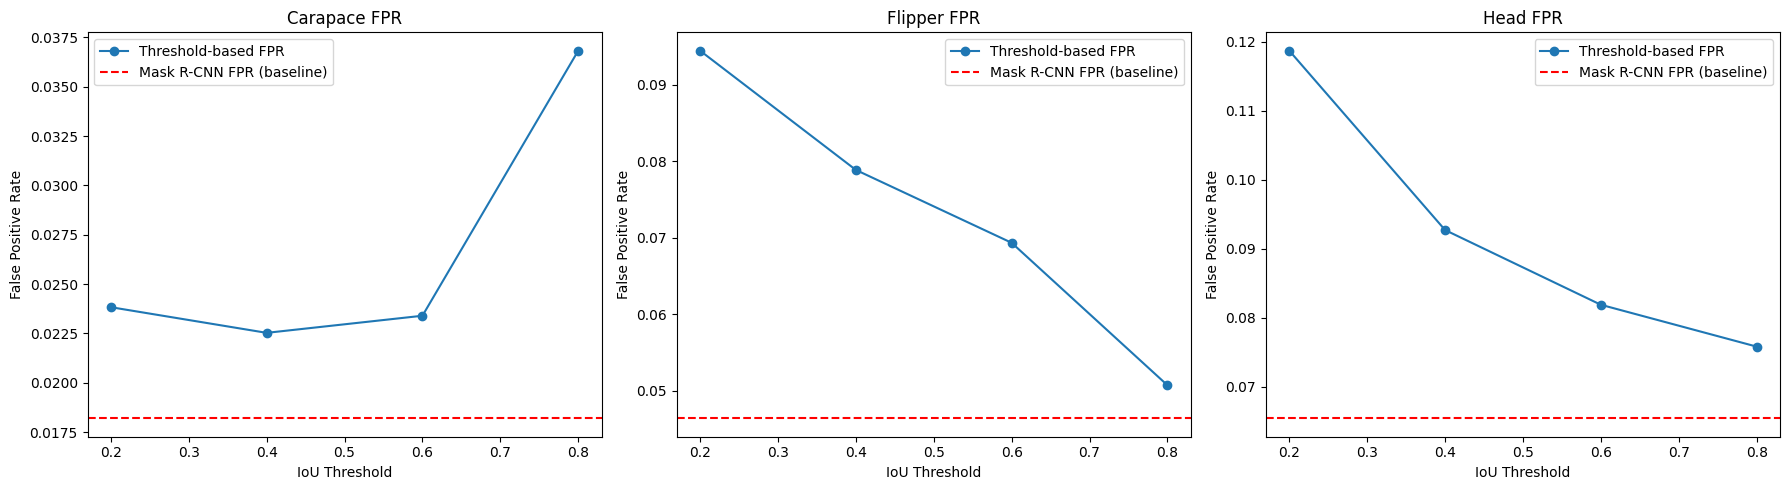

In [50]:
mask_rcnn_fpr = calculate_fp_rate_from_iou_results(mask_rcnn_data)

fpr_results = {cat: [] for cat in ["Carapace", "Flipper", "Head"]}
thresholds = [0.2, 0.4, 0.6, 0.8]

for threshold, filepath in threshold_files.items():
    with open(filepath, 'r') as file:
        iou_data = json.load(file)
        fpr = calculate_fp_rate_from_iou_results(iou_data)
        
        for cat in fpr_results:
            fpr_results[cat].append(fpr[cat])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
categories = ["Carapace", "Flipper", "Head"]

for i, category in enumerate(categories):
    axs[i].plot(thresholds, fpr_results[category], marker='o', label="Threshold-based FPR")
    axs[i].axhline(y=mask_rcnn_fpr[category], color='r', linestyle='--', label="Mask R-CNN FPR (baseline)")
    axs[i].set_title(f"{category} FPR")
    axs[i].set_xlabel("IoU Threshold")
    axs[i].set_ylabel("False Positive Rate")
    axs[i].legend()

plt.tight_layout()
plt.show()